In [107]:
import utils.fetcher_utils as fetcher
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [108]:
pd.set_option('display.max_columns', None)

In [109]:
# Get the data from the IMDb dataFrame
imdb_df = fetcher.aquireIMDbDataFrame()
imdb_df.head()

Reading data from ../resources\movie_metadata.csv


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [110]:
drop_columns = ['movie_imdb_link','aspect_ratio', 'plot_keywords']

imdb_df_filtered = imdb_df.drop(columns=drop_columns)
imdb_df_filtered = imdb_df_filtered.dropna(subset='title_year')


In [111]:
imdb_df_filtered = imdb_df_filtered[sorted(imdb_df_filtered.columns)]

In [112]:
imdb_df_filtered = imdb_df_filtered[(imdb_df_filtered['gross']>1_000) & 
                                    (imdb_df_filtered['budget']>1_000) & 
                                    (imdb_df_filtered['country'] == 'USA') &
                                    (imdb_df['title_year']>1994)].drop(columns='country')
imdb_df_filtered.head(5)

C:\Users\fagui\AppData\Local\Temp\ipykernel_25956\2842505215.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imdb_df_filtered = imdb_df_filtered[(imdb_df_filtered['gross']>1_000) &


,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,budget,cast_total_facebook_likes,color,content_rating,director_facebook_likes,director_name,duration,facenumber_in_poster,genres,gross,imdb_score,language,movie_facebook_likes,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,237000000.0,4834,Color,PG-13,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,Avatar,723.0,3054.0,886204,2009.0
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,300000000.0,48350,Color,PG-13,563.0,Gore Verbinski,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,Pirates of the Caribbean: At World's End,302.0,1238.0,471220,2007.0
3,27000.0,Tom Hardy,23000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,250000000.0,106759,Color,PG-13,22000.0,Christopher Nolan,164.0,0.0,Action|Thriller,448130642.0,8.5,English,164000,The Dark Knight Rises,813.0,2701.0,1144337,2012.0
5,640.0,Daryl Sabara,632.0,Samantha Morton,530.0,Polly Walker,263700000.0,1873,Color,PG-13,475.0,Andrew Stanton,132.0,1.0,Action|Adventure|Sci-Fi,73058679.0,6.6,English,24000,John Carter,462.0,738.0,212204,2012.0
6,24000.0,J.K. Simmons,11000.0,James Franco,4000.0,Kirsten Dunst,258000000.0,46055,Color,PG-13,0.0,Sam Raimi,156.0,0.0,Action|Adventure|Romance,336530303.0,6.2,English,0,Spider-Man 3,392.0,1902.0,383056,2007.0


In [113]:
# len(imdb_df_filtered['actor_1_name'].unique())
# len(set(imdb_df_filtered['actor_2_name'].value_counts().values))

In [114]:
# len(imdb_df_filtered['genres'].unique())
# imdb_df_filtered['genres'].unique()

In [115]:
# imdb_df_filtered[['actor_1_facebook_likes','actor_1_name','actor_2_facebook_likes','actor_2_name','actor_3_facebook_likes', 'director_facebook_likes', 'cast_total_facebook_likes', 'imdb_score', 'director_name']].sort_values(by='actor_1_facebook_likes')


In [116]:
for column in imdb_df_filtered.columns:
    if(imdb_df_filtered[column].dtype == 'object'):
        print(column)
        imdb_df_filtered[column] = imdb_df_filtered[column].fillna('unknown')
        imdb_df_filtered[column] = imdb_df_filtered[column].apply(lambda x: x.strip())

actor_1_name
actor_2_name
actor_3_name
color
content_rating
director_name
genres
language
movie_title


In [117]:
imdb_df_filtered = imdb_df_filtered.fillna(-1)

In [118]:
imdb_df_filtered['movie_title'] = imdb_df_filtered['movie_title'].apply(lambda x: x.strip('\xa0'))
imdb_df_filtered.reset_index(drop=True, inplace=True)

In [119]:
imdb_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   actor_1_facebook_likes     2662 non-null   float64
 1   actor_1_name               2662 non-null   object 
 2   actor_2_facebook_likes     2662 non-null   float64
 3   actor_2_name               2662 non-null   object 
 4   actor_3_facebook_likes     2662 non-null   float64
 5   actor_3_name               2662 non-null   object 
 6   budget                     2662 non-null   float64
 7   cast_total_facebook_likes  2662 non-null   int64  
 8   color                      2662 non-null   object 
 9   content_rating             2662 non-null   object 
 10  director_facebook_likes    2662 non-null   float64
 11  director_name              2662 non-null   object 
 12  duration                   2662 non-null   float64
 13  facenumber_in_poster       2662 non-null   float

In [120]:
imdb_df_filtered.describe()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
count,2662.000000,2662.000000,2662.000000,2.662000e+03,2662.000000,2662.000000,2662.000000,2662.000000,2.662000e+03,2662.000000,2662.000000,2662.000000,2662.000000,2.662000e+03,2662.000000
mean,8593.563862,2294.146882,889.373779,4.329613e+07,12903.489106,796.675808,108.331705,1.464313,5.677188e+07,6.316491,10124.744177,174.410969,342.552216,1.057578e+05,2005.873028
std,17521.141126,4993.587014,2117.382925,4.564704e+07,21357.116127,3129.798221,19.791967,2.206556,7.332626e+07,1.030308,22940.444500,128.185915,418.671868,1.501223e+05,5.784658
min,-1.000000,-1.000000,-1.000000,1.100000e+03,0.000000,0.000000,53.000000,-1.000000,1.111000e+03,1.600000,0.000000,-1.000000,1.000000,2.200000e+01,1995.000000
25%,834.000000,449.250000,245.250000,1.200000e+07,2355.250000,11.000000,95.000000,0.000000,1.088752e+07,5.700000,0.000000,81.000000,110.000000,1.871500e+04,2001.000000
50%,2000.000000,759.500000,488.000000,2.900000e+07,4839.500000,58.500000,105.000000,1.000000,3.339550e+07,6.400000,299.000000,146.000000,210.000000,5.419450e+04,2006.000000
75%,13000.000000,1000.000000,745.000000,6.000000e+07,17683.000000,219.750000,118.000000,2.000000,7.257154e+07,7.000000,12000.000000,233.000000,414.000000,1.311142e+05,2011.000000
max,640000.000000,137000.000000,23000.000000,3.000000e+08,656730.000000,23000.000000,280.000000,43.000000,7.605058e+08,9.000000,349000.000000,813.000000,4667.000000,1.676169e+06,2016.000000


In [121]:
imdb_df_filtered.isna().sum()

actor_1_facebook_likes       0
actor_1_name                 0
actor_2_facebook_likes       0
actor_2_name                 0
actor_3_facebook_likes       0
actor_3_name                 0
budget                       0
cast_total_facebook_likes    0
color                        0
content_rating               0
director_facebook_likes      0
director_name                0
duration                     0
facenumber_in_poster         0
genres                       0
gross                        0
imdb_score                   0
language                     0
movie_facebook_likes         0
movie_title                  0
num_critic_for_reviews       0
num_user_for_reviews         0
num_voted_users              0
title_year                   0
dtype: int64

In [122]:
# Concatenate with a comma separator
imdb_df_filtered['actors'] = imdb_df_filtered[['actor_1_name', 'actor_2_name', 'actor_3_name']].agg(list, axis=1)
imdb_df_filtered['facebook_likes'] = imdb_df_filtered[['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']].agg(list, axis=1)

imdb_df_filtered

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,budget,cast_total_facebook_likes,color,content_rating,director_facebook_likes,director_name,duration,facenumber_in_poster,genres,gross,imdb_score,language,movie_facebook_likes,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,actors,facebook_likes
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,237000000.0,4834,Color,PG-13,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,Avatar,723.0,3054.0,886204,2009.0,"[CCH Pounder, Joel David Moore, Wes Studi]","[1000.0, 936.0, 855.0]"
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,300000000.0,48350,Color,PG-13,563.0,Gore Verbinski,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,Pirates of the Caribbean: At World's End,302.0,1238.0,471220,2007.0,"[Johnny Depp, Orlando Bloom, Jack Davenport]","[40000.0, 5000.0, 1000.0]"
2,27000.0,Tom Hardy,23000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,250000000.0,106759,Color,PG-13,22000.0,Christopher Nolan,164.0,0.0,Action|Thriller,448130642.0,8.5,English,164000,The Dark Knight Rises,813.0,2701.0,1144337,2012.0,"[Tom Hardy, Christian Bale, Joseph Gordon-Levitt]","[27000.0, 23000.0, 23000.0]"
3,640.0,Daryl Sabara,632.0,Samantha Morton,530.0,Polly Walker,263700000.0,1873,Color,PG-13,475.0,Andrew Stanton,132.0,1.0,Action|Adventure|Sci-Fi,73058679.0,6.6,English,24000,John Carter,462.0,738.0,212204,2012.0,"[Daryl Sabara, Samantha Morton, Polly Walker]","[640.0, 632.0, 530.0]"
4,24000.0,J.K. Simmons,11000.0,James Franco,4000.0,Kirsten Dunst,258000000.0,46055,Color,PG-13,0.0,Sam Raimi,156.0,0.0,Action|Adventure|Romance,336530303.0,6.2,English,0,Spider-Man 3,392.0,1902.0,383056,2007.0,"[J.K. Simmons, James Franco, Kirsten Dunst]","[24000.0, 11000.0, 4000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,830.0,Mark Duplass,224.0,Katie Aselton,10.0,Bari Hyman,15000.0,1064,Color,R,157.0,Jay Duplass,85.0,0.0,Comedy|Drama|Romance,192467.0,6.6,English,297,The Puffy Chair,51.0,71.0,4067,2005.0,"[Mark Duplass, Katie Aselton, Bari Hyman]","[830.0, 224.0, 10.0]"
2658,331.0,Zoe Lister-Jones,212.0,Heather Burns,211.0,Ebon Moss-Bachrach,15000.0,1546,Color,unknown,38.0,Daryl Wein,88.0,2.0,Romance,76382.0,6.2,English,324,Breaking Upwards,22.0,8.0,1194,2009.0,"[Zoe Lister-Jones, Heather Burns, Ebon Moss-Ba...","[331.0, 212.0, 211.0]"
2659,291.0,Shane Carruth,45.0,David Sullivan,8.0,Casey Gooden,7000.0,368,Color,PG-13,291.0,Shane Carruth,77.0,0.0,Drama|Sci-Fi|Thriller,424760.0,7.0,English,19000,Primer,143.0,371.0,72639,2004.0,"[Shane Carruth, David Sullivan, Casey Gooden]","[291.0, 45.0, 8.0]"
2660,296.0,Kerry Bishé,205.0,Caitlin FitzGerald,133.0,Daniella Pineda,9000.0,690,Color,Not Rated,0.0,Edward Burns,95.0,1.0,Comedy|Drama,4584.0,6.4,English,413,Newlyweds,14.0,14.0,1338,2011.0,"[Kerry Bishé, Caitlin FitzGerald, Daniella Pin...","[296.0, 205.0, 133.0]"


In [ ]:
# join some columns and explode them 

imdb_df_filtered = imdb_df_filtered.explode(column=['actors', 'facebook_likes'])


imdb_df_filtered

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,budget,cast_total_facebook_likes,color,content_rating,director_facebook_likes,director_name,duration,facenumber_in_poster,genres,gross,imdb_score,language,movie_facebook_likes,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,actors,facebook_likes
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,237000000.0,4834,Color,PG-13,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,Avatar,723.0,3054.0,886204,2009.0,CCH Pounder,1000.0
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,237000000.0,4834,Color,PG-13,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,Avatar,723.0,3054.0,886204,2009.0,Joel David Moore,936.0
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,237000000.0,4834,Color,PG-13,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,Avatar,723.0,3054.0,886204,2009.0,Wes Studi,855.0
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,300000000.0,48350,Color,PG-13,563.0,Gore Verbinski,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,Pirates of the Caribbean: At World's End,302.0,1238.0,471220,2007.0,Johnny Depp,40000.0
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,300000000.0,48350,Color,PG-13,563.0,Gore Verbinski,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,Pirates of the Caribbean: At World's End,302.0,1238.0,471220,2007.0,Orlando Bloom,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,296.0,Kerry Bishé,205.0,Caitlin FitzGerald,133.0,Daniella Pineda,9000.0,690,Color,Not Rated,0.0,Edward Burns,95.0,1.0,Comedy|Drama,4584.0,6.4,English,413,Newlyweds,14.0,14.0,1338,2011.0,Caitlin FitzGerald,205.0
2660,296.0,Kerry Bishé,205.0,Caitlin FitzGerald,133.0,Daniella Pineda,9000.0,690,Color,Not Rated,0.0,Edward Burns,95.0,1.0,Comedy|Drama,4584.0,6.4,English,413,Newlyweds,14.0,14.0,1338,2011.0,Daniella Pineda,133.0
2661,86.0,John August,23.0,Brian Herzlinger,16.0,Jon Gunn,1100.0,163,Color,PG,16.0,Jon Gunn,90.0,0.0,Documentary,85222.0,6.6,English,456,My Date with Drew,43.0,84.0,4285,2004.0,John August,86.0
2661,86.0,John August,23.0,Brian Herzlinger,16.0,Jon Gunn,1100.0,163,Color,PG,16.0,Jon Gunn,90.0,0.0,Documentary,85222.0,6.6,English,456,My Date with Drew,43.0,84.0,4285,2004.0,Brian Herzlinger,23.0


In [124]:
### this might work better

# Calculate the frequency of each category
frequency = imdb_df_filtered['actors'].value_counts()

# Map the frequency back to the original dataframe
imdb_df_filtered['actors_Encoded'] = imdb_df_filtered['actors'].map(frequency)


# Calculate the frequency of each category
frequency = imdb_df_filtered['director_name'].value_counts()

# Map the frequency back to the original dataframe
imdb_df_filtered['directors_Encoded'] = imdb_df_filtered['director_name'].map(frequency)

In [126]:
# # Calculate the mean of the target for each category
# target_mean = imdb_df_filtered.groupby('actors')['imdb_score'].mean()

# # Map the mean back to the original dataframe
# imdb_df_filtered['Category_Encoded'] = imdb_df_filtered['actors'].map(target_mean)

In [127]:
drop_columns = ['actor_1_facebook_likes', 'actor_1_name', 'actor_2_facebook_likes','actor_2_name', 'actor_3_facebook_likes', 'actor_3_name', 'director_name', 'actors', 'movie_title']

In [128]:
imdb_df_filtered.drop(columns=drop_columns)

,budget,cast_total_facebook_likes,color,content_rating,director_facebook_likes,duration,facenumber_in_poster,genres,gross,imdb_score,language,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,facebook_likes,actors_Encoded,directors_Encoded
0,237000000.0,4834,Color,PG-13,0.0,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,723.0,3054.0,886204,2009.0,1000.0,5,6
0,237000000.0,4834,Color,PG-13,0.0,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,723.0,3054.0,886204,2009.0,936.0,5,6
0,237000000.0,4834,Color,PG-13,0.0,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,723.0,3054.0,886204,2009.0,855.0,5,6
1,300000000.0,48350,Color,PG-13,563.0,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,302.0,1238.0,471220,2007.0,40000.0,28,21
1,300000000.0,48350,Color,PG-13,563.0,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,302.0,1238.0,471220,2007.0,5000.0,8,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,9000.0,690,Color,Not Rated,0.0,95.0,1.0,Comedy|Drama,4584.0,6.4,English,413,14.0,14.0,1338,2011.0,205.0,1,9
2660,9000.0,690,Color,Not Rated,0.0,95.0,1.0,Comedy|Drama,4584.0,6.4,English,413,14.0,14.0,1338,2011.0,133.0,1,9
2661,1100.0,163,Color,PG,16.0,90.0,0.0,Documentary,85222.0,6.6,English,456,43.0,84.0,4285,2004.0,86.0,1,9
2661,1100.0,163,Color,PG,16.0,90.0,0.0,Documentary,85222.0,6.6,English,456,43.0,84.0,4285,2004.0,23.0,1,9


In [ ]:
# imdb_df_filtered['genres'] = imdb_df_filtered['genres'].apply(lambda x: x.split('|'))
# imdb_df_filtered = imdb_df_filtered.explode(column='genres')

In [129]:
imdb_df_filtered['content_rating'].value_counts()

content_rating
R            3423
PG-13        3132
PG           1131
G             171
unknown        60
Not Rated      36
Unrated        24
NC-17           9
Name: count, dtype: int64

# Label Encoder

In [130]:
##### do we encode before or after splitting data
### need to fix 

# label_encoder = LabelEncoder()
# object_columns = imdb_df_filtered.select_dtypes(include='object').columns

# for column in object_columns:
#     encoded_column = f"{column}_encoded"  
#     imdb_df_filtered[encoded_column] = label_encoder.fit_transform(imdb_df_filtered[column])

In [131]:
imdb_df_filtered['director_name'].value_counts().head(50)

director_name
Clint Eastwood        48
Steven Soderbergh     42
Steven Spielberg      39
Michael Bay           39
Ridley Scott          36
Shawn Levy            36
Tim Burton            33
Rob Cohen             33
Ron Howard            33
Woody Allen           33
Robert Rodriguez      33
Dennis Dugan          27
Bobby Farrelly        27
Martin Scorsese       27
M. Night Shyamalan    27
Wes Craven            27
Renny Harlin          27
Spike Lee             27
Kevin Smith           27
David Fincher         27
Antoine Fuqua         24
Robert Zemeckis       24
Barry Levinson        24
Richard Linklater     24
James Mangold         24
Brett Ratner          24
Zack Snyder           24
Sam Raimi             24
Christopher Nolan     24
Doug Liman            21
David Ayer            21
Todd Phillips         21
Frank Oz              21
F. Gary Gray          21
Frank Coraci          21
Roland Emmerich       21
Rob Reiner            21
Ang Lee               21
Joel Schumacher       21
Simon West 

In [132]:
imdb_df_numeric = imdb_df_filtered.select_dtypes(include='number')
imdb_df_numeric

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,actors_Encoded,directors_Encoded
0,1000.0,936.0,855.0,237000000.0,4834,0.0,178.0,0.0,760505847.0,7.9,33000,723.0,3054.0,886204,2009.0,5,6
0,1000.0,936.0,855.0,237000000.0,4834,0.0,178.0,0.0,760505847.0,7.9,33000,723.0,3054.0,886204,2009.0,5,6
0,1000.0,936.0,855.0,237000000.0,4834,0.0,178.0,0.0,760505847.0,7.9,33000,723.0,3054.0,886204,2009.0,5,6
1,40000.0,5000.0,1000.0,300000000.0,48350,563.0,169.0,0.0,309404152.0,7.1,0,302.0,1238.0,471220,2007.0,28,21
1,40000.0,5000.0,1000.0,300000000.0,48350,563.0,169.0,0.0,309404152.0,7.1,0,302.0,1238.0,471220,2007.0,8,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,296.0,205.0,133.0,9000.0,690,0.0,95.0,1.0,4584.0,6.4,413,14.0,14.0,1338,2011.0,1,9
2660,296.0,205.0,133.0,9000.0,690,0.0,95.0,1.0,4584.0,6.4,413,14.0,14.0,1338,2011.0,1,9
2661,86.0,23.0,16.0,1100.0,163,16.0,90.0,0.0,85222.0,6.6,456,43.0,84.0,4285,2004.0,1,9
2661,86.0,23.0,16.0,1100.0,163,16.0,90.0,0.0,85222.0,6.6,456,43.0,84.0,4285,2004.0,1,9


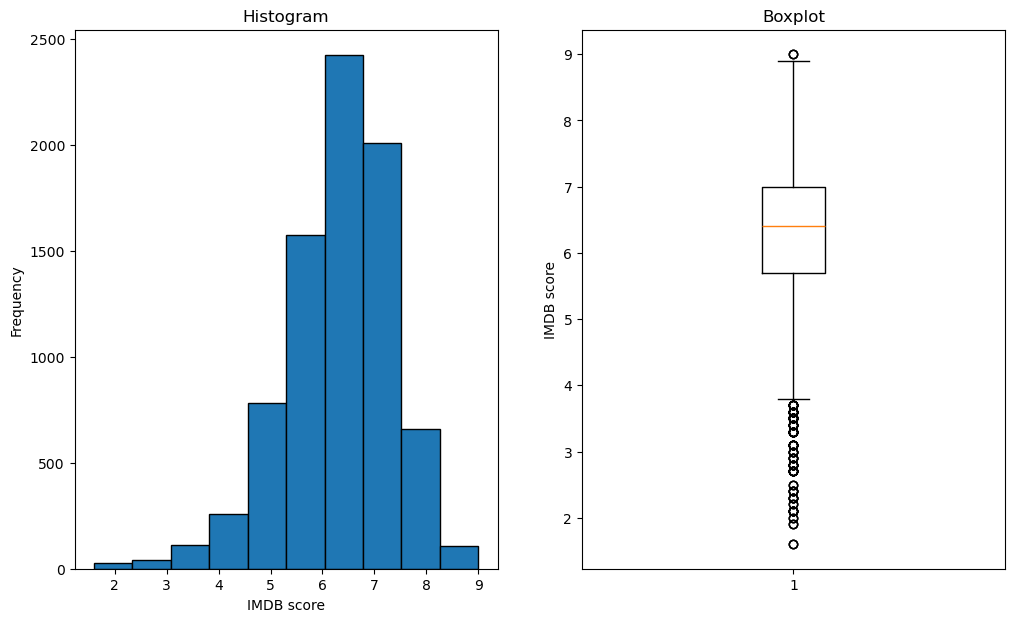

In [133]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot the histogram on the first subplot
ax1.hist(imdb_df_filtered['imdb_score'], bins=10, edgecolor='black')
ax1.set_title('Histogram')
ax1.set_xlabel('IMDB score')
ax1.set_ylabel('Frequency')

# Plot the boxplot on the second subplot
ax2.boxplot(imdb_df_filtered['imdb_score'])
ax2.set_title('Boxplot')
ax2.set_ylabel('IMDB score')

# Show the figure
plt.show()

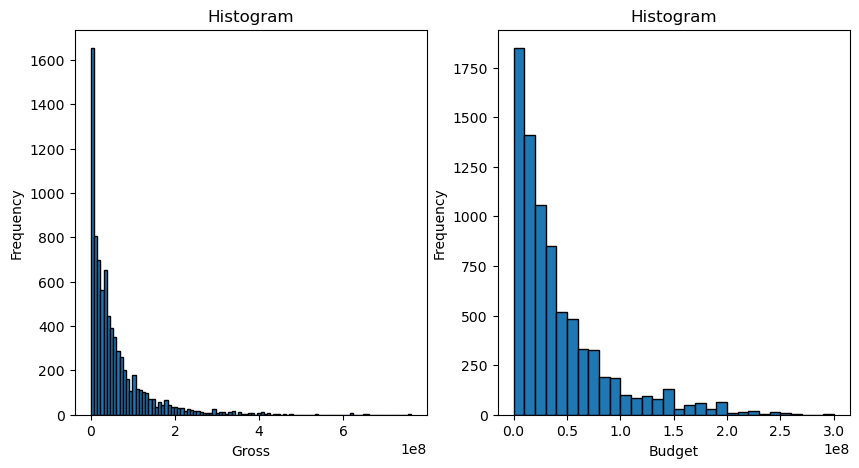

In [134]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram on the first subplot
ax1.hist(imdb_df_filtered['gross'], bins=100, edgecolor='black')
ax1.set_title('Histogram')
ax1.set_xlabel('Gross')
ax1.set_ylabel('Frequency')

# Plot the histogram on the first subplot
ax2.hist(imdb_df_filtered['budget'], bins=30, edgecolor='black')
ax2.set_title('Histogram')
ax2.set_xlabel('Budget')
ax2.set_ylabel('Frequency')

# Show the figure
plt.show()

In [135]:
# gross_na_rows = imdb_df_filtered.loc[imdb_df_filtered['gross'].isna()]
# movie_list = gross_na_rows['movie_title'].apply(lambda x: x.strip('\xa0')).unique()


# million_df = tmdb_df_filtered.loc[tmdb_df_filtered['original_title'].isin(movie_list)].sort_values(by='original_title')
# million_df

# million_df = tmdb_df_filtered[tmdb_df_filtered['original_title'].str.lower().isin([x.lower() for x in movie_list])]
# million_df


In [136]:
# Sample data
data = {
    'Category': ['A', 'B', 'A', 'C', 'B', 'C', 'A', 'D', 'E', 'C'],
    'Target': [1, 0, 1, 0, 1, 0, 1, 1, 0, 0]
}
df = pd.DataFrame(data)

# Calculate the mean of the target for each category
target_mean = df.groupby('Category')['Target'].mean()

# Map the mean back to the original dataframe
df['Category_Encoded'] = df['Category'].map(target_mean)

In [137]:
len(set(imdb_df_filtered.groupby('actor_1_name')['imdb_score'].mean().values))

274

In [138]:
target_mean

Category
A    1.0
B    0.5
C    0.0
D    1.0
E    0.0
Name: Target, dtype: float64

In [139]:
df

,Category,Target,Category_Encoded
0,A,1,1.0
1,B,0,0.5
2,A,1,1.0
3,C,0,0.0
4,B,1,0.5
5,C,0,0.0
6,A,1,1.0
7,D,1,1.0
8,E,0,0.0
9,C,0,0.0
